> Building on normalizations and schedules for Classifier-free Guidance by adding SLERP.  

In [ ]:
#| export: false
import sys
sys.path.insert(0, '/home/paperspace/projects/chaski/')
import matplotlib.pyplot as plt

# Introduction

This notebook builds on our [first one] to run more experiments on changing the CFG parameter during diffusion.  

To recap the previous results, it seems that normalizing and scheduling the guidance parameter improves generated Diffusion images. Specifically:  

- Normalizing CFG improves the image's syntax.  
- Scheduling CFG helps with image details.  

The combination of the two often generates higher quality, more correct outputs.  

## Bringing in SLERP. 

Here we take the next step: SLERP interpolation. Let's dive into the details.    

In our previous normalization and scheduling, we are still doing a type of linear interpolation. Remember that we call the unconditioned latents $u$ and the conditional latents $t$. The standard CFG interpolates between $u$ and the difference $\left(t - u\right)$.  


This raises the questions: given how [Guassians work in high dimensions](https://www.inference.vc/high-dimensional-gaussian-distributions-are-soap-bubble/), can we do better? What if instead of linearly interpolating the vectors, we spherically interpolated them instead?  


Specifically, instead of:  

$$u + G\left(t - u\right)$$  

We instead now do an update like:  

$$\text{SLERP}(u, G(t-u), \alpha)$$   

Where $\alpha$ is the SLERP interpolation parameter.   

This brings up a fresh set of questions:  

- How do we handle $G$?  
- Should we interpolate $u$ and $t$?  Or $\left(t - u\right)$?  
- Which of the vectors should we normalize, and when?  
- What type of schedule makes sense for $\alpha$? If any?   

These are complicated questions that deserve a lot of exploration to be fully answered. To start, we can try to learn more about how $u$ and $t$ change during diffusion.  

# Measuring latent changes

SLERP is based entirely on the angle between two vectors.  

If the vectors are close to parallel, then SLERP does not work and we need to linearly interpolate them instead.  

If the vectors are orthogonal, then SLERP will always interpolate to the midpoint of the arc between the normalized vectors.  

Any other angle situation will fall in between these cases.  

To figure out what exactly is happening with $u$ and $t$, we can measure the angle between them during the diffusion process. Do they drift together, move apart, or follow a totally random path?  

## Measuring the angle between latent vectors

Let's write a quick function that will let us find the angle between two latent vectors.  

We find the dot product and, if it's below a parallel threshold, we compute the angle between the vectors.  

In [ ]:
# def get_latents_angle(v1, v2, DOT_THR=0.9995):  
    
#     # take the dot product between the normalized vectors
#     dot = ((v1 / (torch.linalg.norm(v1))) * (v2 / torch.linalg.norm(v2))).sum()
    
#     # if the vectors are too close, return a simple linear interpolation
# #     if torch.abs(dot) > DOT_THR:
# #         print(f'warning: v1 and v2 close to parallel with dot_product={dot.item()}.\narcos might not work.')
        
#     theta = torch.acos(dot)
#     if torch.isnan(theta).any():
#         theta = 0
    
#     return theta

import numpy as np
def get_latents_angle(v0, v1, DOT_THRESHOLD=0.9995):
    """ helper function to spherically interpolate two arrays v1 v2 """

    if not isinstance(v0, np.ndarray):
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

#     dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    norm_v0 = v0 / np.linalg.norm(v0)
    norm_v1 = v1 / np.linalg.norm(v1)
    dot = np.sum(norm_v0 * norm_v1)
    
    if np.abs(dot) > DOT_THRESHOLD:
        #print(f'warning: v1 and v2 close to parallel with dot_product={dot.item()}.\narcos might not work.')
        #v2 = (1 - t) * v0 + t * v1
        theta_0 = 0#arccos(dot)
    else:
        theta_0 = np.arccos(dot)
        
    return torch.tensor(theta_0)




def get_latents_angle(start, end):
    if not isinstance(start, np.ndarray):
        input_device = start.device
        start = start.cpu().numpy()
        end = end.cpu().numpy()
    
    # create an orthogonal basis using QR decomposition
    basis = np.vstack([start, end])
    Q, R = np.linalg.qr(basis.T)
    signs = 2 * (np.diag(R) >= 0) - 1
    Q = Q.T * signs.T[:, np.newaxis]
    R = R.T * signs.T[:, np.newaxis]

    # calculate the angle between `start` and `end`
    c = np.dot(start, end)
    s = np.linalg.det(R)
    omega = np.arctan2(s, c)
    return omega

#     # interpolate
#     start, end = Q
#     s = np.sin(t * omega)
#     c = np.cos(t * omega)
#     return start * c[:, np.newaxis] + end * s[:, np.newaxis]

### Leveraging previous code

Below we bring in some of the helper functions and code from the previous notebook.  

They are mainly helper functions and imports to generate Diffusion images.  

In [ ]:
import os
import math
import random
import warnings
from PIL import Image
from typing import List
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from tqdm.auto import tqdm 

# imports for diffusion models
import torch
from transformers import logging
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

# use cosine scheduler from timm
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.optim import create_optimizer
from timm import create_model

# for clean outputs
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

# set the hardware device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

2022-11-18 01:31:01.382553: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Setting the prompt

In [ ]:
# the input prompt for diffusion
# prompt = "a photograph of an astronaut riding a horse"
prompt = "mdjrny-v4 style nft style, cyberpunk, synthwave, tarot card with intricate detailed frame around the outside | with cyberglasses neon, and earphone, dj sound, futuristic, gold, diamond, side profile of cyberpunk body with cyborg skull | cyberpunk | styled in Art Nouveau | insanely detailed | embellishments | high definition | concept art | digital art | vibrant"

# set the diffusion model
# model_name = "CompVis/stable-diffusion-v1-4" # "runwayml/stable-diffusion-v1-5"
model_name = "prompthero/midjourney-v4-diffusion"

In [ ]:
def text_embeddings(prompts, maxlen=None):
    "Extracts text embeddings from the given `prompts`."
    maxlen = maxlen or tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0]


def image_from_latents(latents):
    "Scales the diffusion `latents` and turns them into a PIL Image."
    
    # scale and decode the latents
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        data = vae.decode(latents).sample[0]

    # Create PIL image
    data = (data / 2 + 0.5).clamp(0, 1)
    data = data.cpu().permute(1, 2, 0).float().numpy()
    data = (data * 255).round().astype("uint8")
    image = Image.fromarray(data)
    return image
    
    
def show_image(image, scale=0.5):
    "Displays the given `image` resized based on `scale`."
    img = image.resize(((int)(image.width * scale), (int)(image.height * scale)))
    display(img)
    return img


def image_grid(images, rows = 1, width=256, height=256, title=None):
    "Display an array of images in a nice grid, or single row"
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            txt = f'Frame: {index}'
            if title is not None:
                if isinstance(title, str):
                    txt = f'{title}: {index}'
                elif isinstance(title, List):
                    txt = title[index]
            # small change for bigger, more visible titles
            txt = '\n'.join(wrap(txt, width=70))
            ref.set_title(txt, fontsize='x-large')
            ref.imshow(img)
            ref.axis('off')
            

In [ ]:
def get_sd_pieces(model_name, dtype=torch.float32):
    "Loads and returns the individual pieces in a Diffusion pipeline."
    
    # create the tokenizer and text encoder
    tokenizer = CLIPTokenizer.from_pretrained(
        model_name,
        subfolder="tokenizer",
        torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained(
        model_name,
        subfolder="text_encoder",
        torch_dtype=dtype).to(device)

    # we are using a VAE from stability that was trained for longer than the baseline 
    vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=dtype).to(device)
    ## NOTE: we can also use these vae from Stability that were trained for even longer
    #vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=dtype).to(device)
    
    # build the unet
    unet = UNet2DConditionModel.from_pretrained(
        model_name,
        subfolder="unet",
        torch_dtype=dtype).to(device)
    
    # enable unet attention slicing
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)
        
    # build the scheduler
    scheduler = LMSDiscreteScheduler.from_config(model_name, subfolder="scheduler")
    
    return (
        tokenizer,
        text_encoder,
        vae,
        unet,
        scheduler,
    )


# load the individual diffusion pieces
pieces = get_sd_pieces(model_name, dtype=torch.float32)
(tokenizer, text_encoder, vae, unet, scheduler) = pieces

Let's re-use our Guidance Transformation class `GuidanceTfm`

In [ ]:
from chaski.guidance_tfm import *

Create a simple schedule

In [ ]:
max_g = 7.5
num_steps = 50
max_sched  = {'g': [max_g] * num_steps}

# constant schedule with min guidance
min_g = 0.15
min_sched  = {'g': [min_g] * num_steps}

baseline_guidance = GuidanceTfm(max_sched)
# baseline_guidance = TNormGuidance(min_sched)
# baseline_guidance = FullNormGuidance(min_sched)

Next we define the image generation functions.  
We add in a new, patchy "hook" to compute and store the angles between $u$ and $t$ to see how they evolve during Diffusion.  

### Slerp variants

In [ ]:
def slerp_np(start, end, t):
    if not isinstance(start, np.ndarray):
        input_device = start.device
        input_dtype = start.dtype
        start = start.cpu().numpy()
        end = end.cpu().numpy()
    
    # create an orthogonal basis using QR decomposition
    basis = np.vstack([start, end])
    Q, R = np.linalg.qr(basis.T)
    signs = 2 * (np.diag(R) >= 0) - 1
    Q = Q.T * signs.T[:, np.newaxis]
    R = R.T * signs.T[:, np.newaxis]

    # calculate the angle between `start` and `end`
    c = np.dot(start, end)
    s = np.linalg.det(R)
    omega = np.arctan2(s, c)
    
    # interpolate
    start, end = Q
    s = np.sin(t * omega)
    c = np.cos(t * omega)
    mix =  (start * c[:, np.newaxis]) + (end * s[:, np.newaxis])
    
    mix = torch.from_numpy(mix).to(input_dtype).to(input_device)
    return mix


def slerp_pt(low, high, val, zdim=1):
    low_norm = low/torch.norm(low, dim=zdim, keepdim=True)
    high_norm = high/torch.norm(high, dim=zdim, keepdim=True)
    omega = torch.acos((low_norm*high_norm).sum(zdim))
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so).unsqueeze(zdim)*low + (torch.sin(val*omega)/so).unsqueeze(zdim) * high
    return res 



def slerp(v1, v2, t, DOT_THR=0.9995, to_cpu=False):
    """SLERP for pytorch tensors interpolating `v1` to `v2` with scale of `t`.
    
    Does a regular linear interpolation when the vectors are too close to parallel.
        I.E. when their dot product is above `DOT_THR`.  

    Theory Reference:
        https://splines.readthedocs.io/en/latest/rotation/slerp.html
    
    PyTorch reference:
        https://discuss.pytorch.org/t/help-regarding-slerp-function-for-generative-model-sampling/32475/3
        
    Numpy reference: 
        https://gist.github.com/dvschultz/3af50c40df002da3b751efab1daddf2c
    """
    
    # check if we need to compute on the cpu
    if to_cpu:
        orig_device = v1.device
        v1, v2 = v1.to('cpu'), v2.to('cpu')
    
    # take the dot product between normalized vectors
    dot = torch.mul(v1/torch.linalg.norm(v1), v2/torch.linalg.norm(v2)).sum()
    
    # if the vectors are too close, return a simple linear interpolation
    if torch.abs(dot) > DOT_THR:
        print(f'warning: v1 and v2 close to parallel, using linear interpolation instead.')
        res = (1 - t) * v1 + t * v2    
    
    # else, apply SLERP
    else:
        # compute the angle terms we need
        theta   = torch.acos(dot)
        theta_t = theta * t
        sin_theta   = torch.sin(theta)
        sin_theta_t = torch.sin(theta_t)
        
        # compute the sine scaling terms for the vectors
        s1 = torch.sin(theta - theta_t) / sin_theta
        s2 = sin_theta_t / sin_theta
        
        # interpolate the vectors
        res = (s1 * v1) + (s2 * v2)
        
    # check if we need to move back to the original device
    if to_cpu: res.to(orig_device)
        
    return res

## Generate images

In [ ]:
# create the shared, initial latents
width, height = 512, 512

# stores the angle at each timestep
angles = {}

# grab the initial set of latents
seed = 1024
torch.manual_seed(seed)
init_latents = torch.randn((1, unet.in_channels, height//8, width//8), dtype=unet.dtype, device=device)

prev_latents = None
def generate(prompt, gtfm=None, width=width, height=height, guidance=max_g, steps=num_steps, **kwargs):
    # make sure we got a guidance function
    assert gtfm
    
    # prepare text embeddings
    text = text_embeddings(prompt)
    uncond = text_embeddings('')
    emb = torch.cat([uncond, text]).type(unet.dtype)
    
    # start from the shared, initial latents
    latents = torch.clone(init_latents)
    scheduler.set_timesteps(steps)
    latents = latents * scheduler.init_noise_sigma
    
    # to slerp between prompts
    prompt_mix = np.linspace(0, 0.5, num_steps)
    
    # run diffusion
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): 
            tf = ts
            if torch.has_mps:
                tf = ts.type(torch.float32)
                
            # find slerp between the prompts
            slerp_text = text#slerp_pt(text, uncond, prompt_mix[i], zdim=2)
            slerp_uncond = slerp_pt(uncond, text, prompt_mix[i], zdim=2)
            slerp_emb = torch.cat([slerp_uncond, slerp_text]).type(unet.dtype)
            u,t = unet(inp, tf, encoder_hidden_states=slerp_emb).sample.chunk(2)
            
            # prompts without slerp
            #u,t = unet(inp, tf, encoder_hidden_states=emb).sample.chunk(2)
        
        # run the guidance transform
        pred = gtfm.encode(u, t, idx=i)

        # step the latents through the diffusion process
        latents = scheduler.step(pred, ts, latents).prev_sample
        
    # decode and return the final latents
    image = image_from_latents(latents)
    return image    

Now we can run the generation process. We store the final image just to make sure the generation was ok. 

In [ ]:
img = generate(prompt, baseline_guidance)

  0%|          | 0/50 [00:00<?, ?it/s]

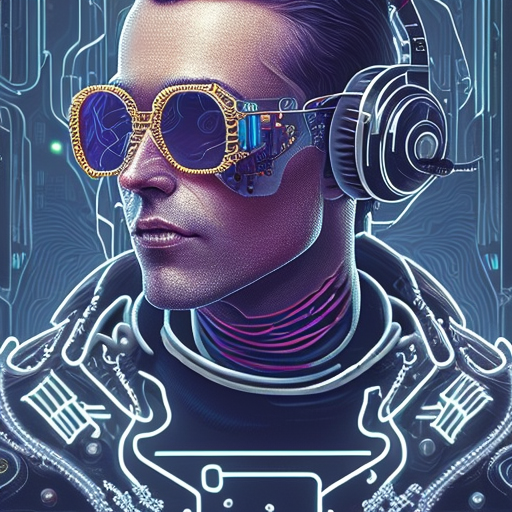

In [ ]:
img

## Plot the angles during Diffusion

In [ ]:
import math
def rad2angle(o): return o * (180 / math.pi)

In [ ]:
def get_cos_sched(num_steps: int = 50,
                  max_val: float = 7.5,
                  min_val: float = 0.15,
                  num_cycles: float = 0.5,
                  num_warmup_steps: int = 0,
                  warmup_init_val: float = 0.,
                  k_decay:float = 1.,
                  cycle_mul: float = 1.,
                  cycle_decay:float = 1.,
                  cycle_limit = 1.,
    ) -> list:
    '''Creates a cosine schedule based on the given parameters.
    
    Args:
        num_steps: Number of total steps in the schedules. 
        max_val: The maximum value in the schedule. 
        min_val: The minimum number in the schedule. 
        num_cycles: How many full cosine schedules to sweep. By default, 0.5.
        num_warmup_steps: Over how many steps to warmup.  
        cycle_mul: Param for timm scheduler.
        cycle_decay: Param for timm schedulers.
        cycle_limit: Param for timm schedulers.
        k_decay: Param for timm schedulers.  
        
    The cycle_* and k_decay `timm` parmeters are described in better detail here:
        https://timm.fast.ai/SGDR#CosineLRScheduler
    These args offer a lot of powerful flexibility in guiding the cosine scheduler.
        TODO: experiment with these settings for diffusion.  
        
    NOTE: cycle_* parameters might not work as intended, since we are dealing with "one" epoch.
        TODO: investigate
    
    Based on a combo of HuggingFace and timm schedulers:
        https://github.com/rwightman/pytorch-image-models/blob/main/timm/scheduler/cosine_lr.py
        https://github.com/huggingface/transformers/blob/v4.24.0/src/transformers/optimization.py#L104
    '''

    def cos_sched_helper(current_step):
        "Helper to compute cosine values."
        
        # get the warmup value
        if current_step < num_warmup_steps:
            return warmup_init_val + float(current_step * (max_val - warmup_init_val)) / float(max(1, num_warmup_steps))
        
        # else get the regular scheduled values
        else:

            if cycle_mul != 1:
                i = math.floor(math.log(1 - current_step / num_steps * (1 - cycle_mul), cycle_mul))
                t_i = cycle_mul ** i * num_steps
                t_curr = current_step - (1 - cycle_mul ** i) / (1 - cycle_mul) * num_steps
            else:
                i = current_step // num_steps #
                t_i = num_steps
                t_curr = current_step - (num_steps * i)

            # find the scaled maximum value based on cycle_decay
            gamma = cycle_decay ** i
            scaled_max = max_val * gamma
            scaled_mag = 0.5 * (scaled_max - min_val)
            
            # find completion offset based on current step and k-decay
            t_curr = (t_curr - num_warmup_steps)
            t_i = max(1, num_steps - num_warmup_steps)
            scaled_progress = (t_curr ** k_decay) / (t_i ** k_decay)
            
            if i < cycle_limit:
                cos_val = (1 + math.cos(math.pi * 2 * num_cycles * scaled_progress))
                val = min_val + scaled_mag * cos_val
            else:
                val = min_val

            return val

    # get the actual schedule value
    vals = [cos_sched_helper(i) for i in range(num_steps)]
    return vals


In [ ]:
# creating a few cos schedules

# cosine scheduler
max_val = 7.5
min_val = 0.15
num_steps = 50
num_warmup_steps = 5
num_training_steps = num_steps
num_cycles = 2


# cosine schedule parameters
cos_params = {
    'max_val':         max_val,
    'num_steps':       num_steps,
    'min_val':         min_val,
    'num_warmup_steps':    0,
}

# warmup-cosine parameters
warmup_cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  num_warmup_steps,
}

# cosine schedule for T-Norm guidance
t_scale_params = {
    'max_val':         0.25,
    'num_steps':       num_steps,
    'min_val':         0.05,
}

default_g = get_cos_sched(**cos_params)
warmup_g = get_cos_sched(**warmup_cos_params)
TNorm_g = get_cos_sched(**t_scale_params)

plt.plot(default_g)

plt.plot(warmup_g)

plt.plot(TNorm_g)